In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

## Black Scholes Greeks

Ref: B.4, Mark Joshi

In [2]:
# BSM

def BSM(S0,K, r, T, v,type='c'):
    d1=(np.log(S0 / K) + (r + v**2 / 2.0) * T) / (v * np.sqrt(T))
    d2=d1-v * np.sqrt(T)
    try:
        if type=='c':
            BSM=S0*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
        elif type=='p':
            BSM=-S0*norm.cdf(-d1)+K*np.exp(-r*T)*norm.cdf(-d2)
        return BSM
    except:
        print('type is c for call and p for put')

        
#MC      
def payoff(S_T,K,type='c'): # can be any payoff
    try:
        if type=='c':
            payoff=np.maximum(S_T-K,np.zeros(len(S_T)))
        elif type=='p':
            payoff=np.maximum(-S_T+K,np.zeros(len(S_T)))
        return payoff # returns an array of payoffs
    except:
        print('type is c for call and p for put')
    

def MC_stock(N,S0,r,T,v,d=0,seed=False): # d is drift
    if seed:
        np.random.seed(42)
    Z=np.random.normal(0,1,N) # generate N random numbers
    Z=np.append(Z,-Z) # make distributino symmetrical, helps with faster convergence
    S_T=S0*np.exp((r-d)*T-v**2 *T/2 +v*np.sqrt(T)*Z)
    return S_T

def MC_option(N,S0,K, r, T, v,d=0,type='c',seed=False):
    S_T=MC_stock(N,S0,r,T,v,seed=seed)
    disc_avg_payoff=np.exp(-r*T)*np.sum(payoff(S_T,K,type))/len(S_T)
    return disc_avg_payoff 


#GREEKS

# Delta- der of price wrt spot S
def delta(S0,K, r, T, v,type='c'):
    d1=(np.log(S0 / K) + (r + v**2 / 2.0) * T) / (v * np.sqrt(T))
    d2=d1-v * np.sqrt(T)
    try:
        if type=='c':
            delta=norm.cdf(d1,0,1)
        elif type=='p':
            delta=-norm.cdf(-d1,0,1)
        return delta
    except:
        print('type is c for call and p for put')
            

# gamma- der of delta wrt S
def gamma(S0,K, r, T, v,type='c'):
    d1=(np.log(S0 / K) + (r + v**2 / 2.0) * T) / (v * np.sqrt(T))
    d2=d1-v * np.sqrt(T)
    gamma=norm.pdf(d1, 0, 1)/(S0*v*np.sqrt(T)) # same for c and p, note: pdf not cdf
    
    return gamma

    
# vega- der of price wrt v
def vega(S0,K, r, T, v,type='c'):
    d1=(np.log(S0 / K) + (r + v**2 / 2.0) * T) / (v * np.sqrt(T))
    d2=d1-v * np.sqrt(T)
    vega=norm.pdf(d1,0,1)*S0*np.sqrt(T)
    return vega



    
#theta- negative of der of price wrt T
def theta(S0,K, r, T, v,type='c'):
    d1=(np.log(S0 / K) + (r + v**2 / 2.0) * T) / (v * np.sqrt(T))
    d2=d1-v * np.sqrt(T)
    try:
        if type=='c':
            theta=-S0*norm.pdf(d1, 0, 1)*v/(2*np.sqrt(T)) - r*K*np.exp(-r*T)*norm.cdf(d2, 0, 1)
        elif type=='p':
            theta=-S0*norm.pdf(d1, 0, 1)*v/(2*np.sqrt(T)) +r*K*np.exp(-r*T)*norm.cdf(-d2, 0, 1)
        return theta
    except:
        print('type is c for call and p for put')
        
# rho- der of price wrt r
def rho(S0,K, r, T, v,type='c'):
    d1=(np.log(S0 / K) + (r + v**2 / 2.0) * T) / (v * np.sqrt(T))
    d2=d1-v * np.sqrt(T)
    try:
        if type=='c':
            rho=K*T*np.exp(-r*T)*norm.cdf(d2, 0, 1)
        elif type=='p':
            rho=-K*T*np.exp(-r*T)*norm.cdf(-d2, 0, 1)
        return rho
    except:
        print('type is c for call and p for put')

In [3]:
# implementing and testing the formulas for calls

S0=20
K=18
r=0.05
T=1.5
v=0.2

ep=0.05
t='p'


# delta
d=(BSM(S0+ep,K, r, T, v,t)-BSM(S0,K, r, T, v,t))/ep
N=1000000
dmc=(MC_option(N,S0+ep,K, r, T, v,0,t,seed=True)-MC_option(N,S0,K, r, T, v,0,t,seed=True))/ep # note: seed should be same with the two MC
print(d)
print(dmc)
delta(S0,K, r, T, v,t).round(5)

-0.193824620430183
-0.19405394962596523


-0.19523

In [4]:
#gamma
g1=(delta(S0+ep,K, r, T, v,t)-delta(S0,K, r, T, v,t))/ep
g2=(BSM(S0+ep,K, r, T, v,t)+BSM(S0-ep,K, r, T, v,t)-2*BSM(S0,K, r, T, v,t))/ep**2
print(g1,g2)
gamma(S0,K, r, T, v,t)

0.05600198376052412 0.056318956516321336


0.05631871765636101

In [5]:
# theta
ep=T/100
th=-(BSM(S0,K, r, T+ep, v,t)-BSM(S0,K, r, T, v,t))/ep
print(th)
theta(S0,K, r, T, v,t)

-0.22418770375714678


-0.225392688605703

In [6]:
# rho
ep=r/100
rh=(BSM(S0,K, r+ep, T, v,t)-BSM(S0,K, r, T, v,t))/ep
print(rh)
rho(S0,K, r, T, v,t)

-6.739521758796663


-6.754711579355553

In [7]:
# vega
ep=v/100
vg=(BSM(S0,K, r, T, v+ep,t)-BSM(S0,K, r, T, v,t))/ep
print(vg)
vega(S0,K, r, T, v,t)

6.775907224833455


6.75824611876332

## Plotting Greeks

Text(0.5, 1.0, 'vs spot')

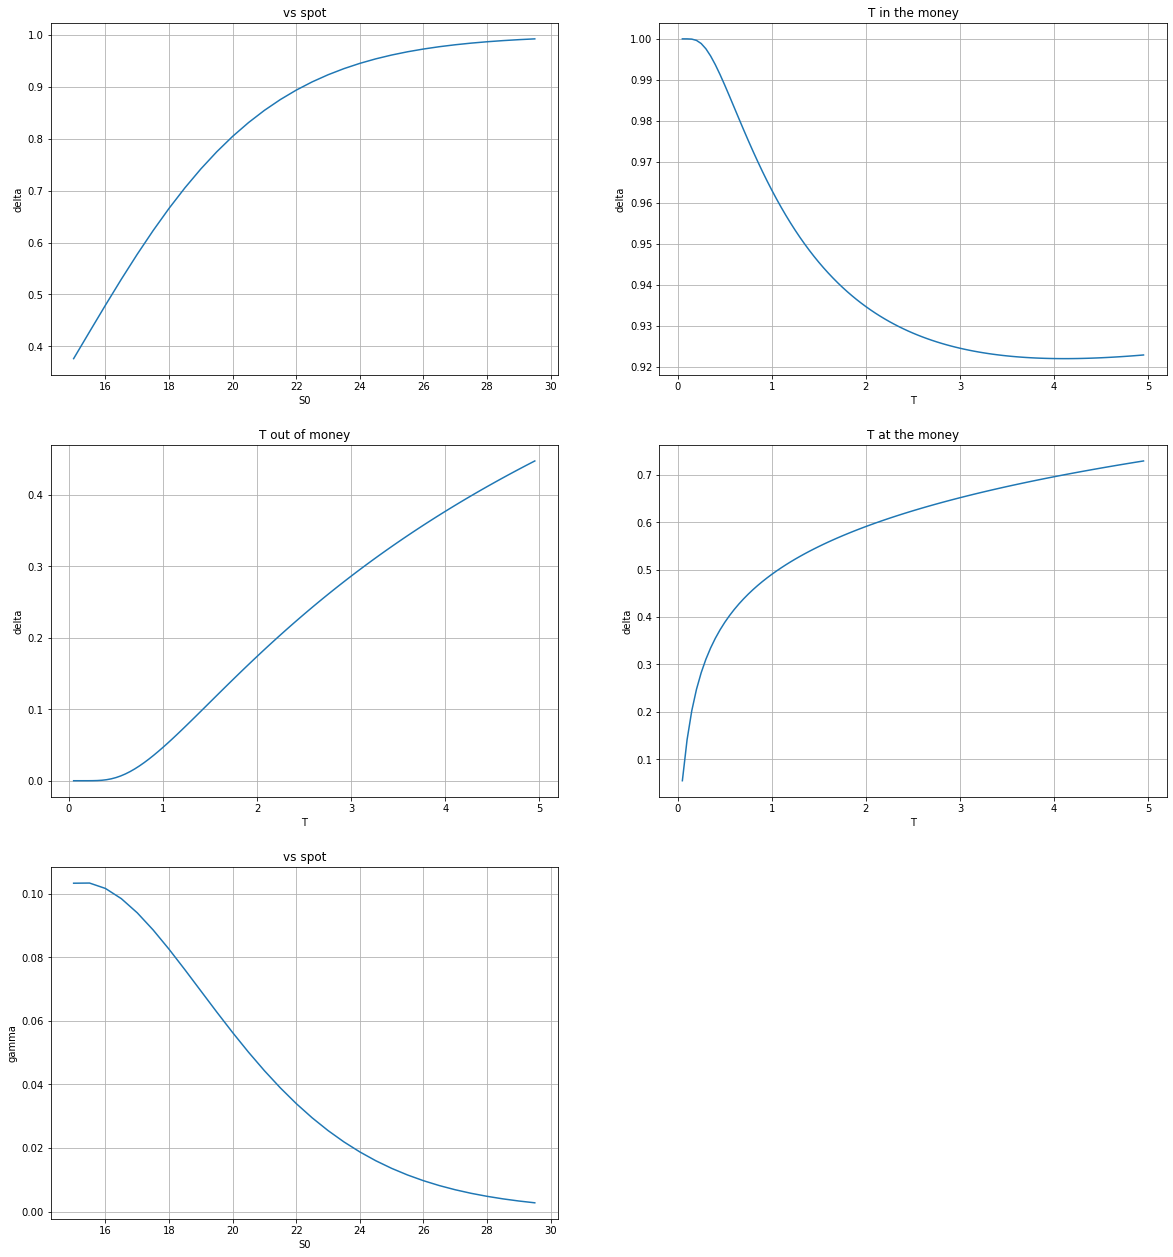

In [8]:
plt.figure(figsize=(20,22))

plt.subplot(3,2,1)
plt.plot(np.arange(15,30,0.5),delta(np.arange(15,30,0.5),K,r,T,v))
plt.xlabel('S0')
plt.ylabel('delta')
plt.grid()
plt.title('vs spot')

plt.subplot(3,2,2)
plt.plot(np.arange(0.05,5,0.05),delta(K+6,K,r,np.arange(0.05,5,0.05),v))#in the money
plt.xlabel('T')
plt.ylabel('delta')
plt.grid()
plt.title('T in the money')

plt.subplot(3,2,3)
plt.plot(np.arange(0.05,5,0.05),delta(K-6,K,r,np.arange(0.05,5,0.05),v))#out of money
plt.xlabel('T')
plt.ylabel('delta')
plt.grid()
plt.title('T out of money')

plt.subplot(3,2,4)
plt.plot(np.arange(0.05,5,0.05),delta(K *np.exp(-r*T),K,r,np.arange(0.05,5,0.05),v))#at the money
plt.xlabel('T')
plt.ylabel('delta')
plt.grid()
plt.title('T at the money')

plt.subplot(3,2,5)
plt.plot(np.arange(15,30,0.5),gamma(np.arange(15,30,0.5),K,r,T,v))
plt.xlabel('S0')
plt.ylabel('gamma')
plt.grid()
plt.title('vs spot')

Text(0.5, 1.0, 'vs T')

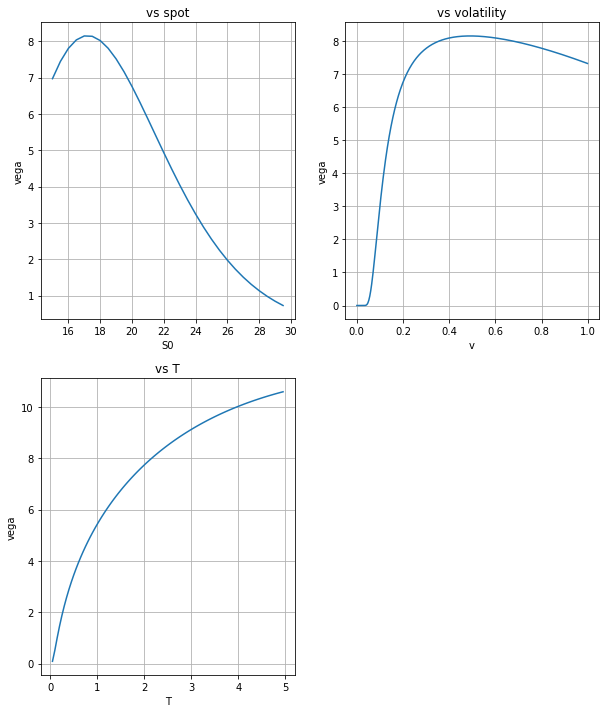

In [9]:
# plot of gamma

plt.figure(figsize=(10,12))

plt.subplot(2,2,1)
plt.plot(np.arange(15,30,0.5),vega(np.arange(15,30,0.5),K,r,T,v))
plt.xlabel('S0')
plt.ylabel('vega')
plt.grid()
plt.title('vs spot')

plt.subplot(2,2,2)
plt.plot(np.arange(0.0001,1,0.002),vega(S0,K,r,T,np.arange(0.0001,1,0.002)))
plt.xlabel('v')
plt.ylabel('vega')
plt.grid()
plt.title('vs volatility')

plt.subplot(2,2,3)
plt.plot(np.arange(0.05,5,0.05),vega(S0,K,r,np.arange(0.05,5,0.05),v))
plt.xlabel('T')
plt.ylabel('vega')
plt.grid()
plt.title('vs T')

## Hedging vanilla Call

Ref: B.5, Mark Joshi

Remove uncertainity in final payoff by trading in the underlying.

In [10]:
# create stock paths
def stock_path(N,S0,r,T,v,d=0,M=1,seed=False): # d is drift, N: how granular you want the path, T: till time, steps=T/N
    if seed:
        np.random.seed(42)
    dt=T/N
    S_paths=[]
    for j in range(M):
        #t=0
        S=S0
        S_path=[]
        for i in range(N):
            Z=np.random.normal(0,1)
            S_path.append(S)
            S=S*np.exp((r-d)*dt-v**2 *dt/2 +v*np.sqrt(dt)*Z)
            #print(Z)
            #t=t+dt
        S_paths.append(S_path)
    #print(t)    
    return np.array(S_paths)

# port_val of replication portfolio, delta-hedges
def replicate(N,S0,K,r,T,v,d=0,M=1,seed=False):
    s=stock_path(N,S0,r,T,v,M=M)
    C_in=BSM(S0,K, r, T, v) #initial value of option-- and -- initial value of the replication portfolio
    delta_matrix=delta(s,K, r, T, v) # amount of stocks at each point in the rep portf
    buy_sell_matrix=np.diff(delta_matrix,axis=1)# rebalancing of the rep portfolio, perfect hedge is continuous reb
    buy_sell_price=s[:,1:N]*buy_sell_matrix
    bank_in=C_in-delta_matrix[:,0]*S0 # initial amount in bank
    bank=np.zeros((M,N))
    bank[:,0]=bank_in
    for i in range(1,N):
        bank[:,i]=np.exp(r*T/N)*bank[:,i-1]-buy_sell_price[:,i-1]
    port_val=bank+delta_matrix*s 
    return {'port_val':port_val,'S_paths':s}

In [11]:
N=360
T=1

S0=10
K=10
r=0.05
v=0.1

In [12]:
M=1000
s=stock_path(N,S0,r,T,v,M=M)

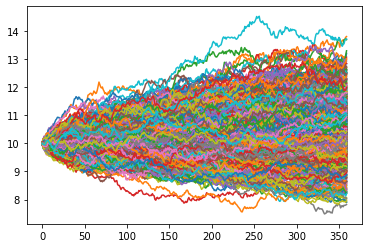

In [13]:
for i in range(M):
    plt.plot(s[i])


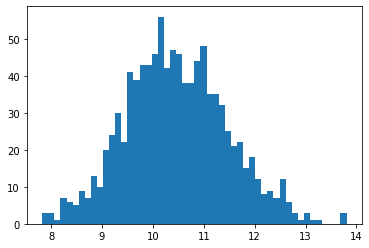

In [14]:
# convergence of M-- get log normal distribution for last values of each path
plt.hist(s[:,-1],bins=50)
plt.show()

In [15]:
result=replicate(N,S0,K,r,T,v,M=M,seed=True)
port_val=result['port_val']
s=result['S_paths']

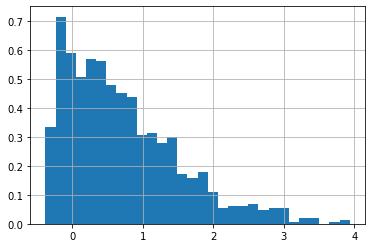

In [68]:
plt.hist(port_val[:,-1],bins=30,density=True)
plt.grid()
plt.show()

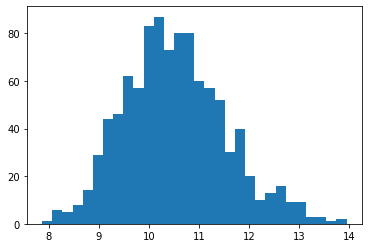

In [67]:
plt.hist(s[:,-1],bins=30)
plt.show()

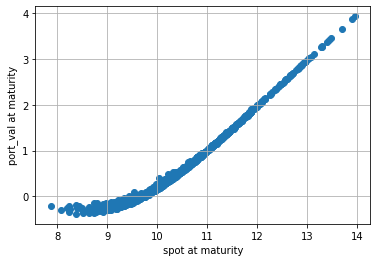

In [66]:
plt.scatter(s[:,-1],port_val[:,-1])
plt.xlabel('spot at maturity')
plt.ylabel('port_val at maturity')
plt.grid()
plt.show()

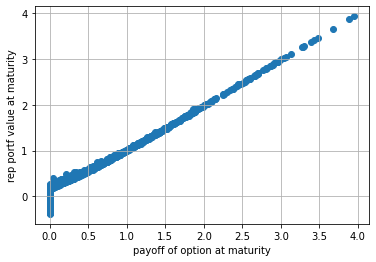

In [65]:
plt.scatter(x=np.maximum(s[:,-1]-K,0),y=port_val[:,-1])
plt.xlabel('payoff of option at maturity')
plt.ylabel('rep portf value at maturity')
plt.grid()
plt.show()

#### We, see the replicating portfolio with dynamic hedging at frequency N/T is able to replicate the payoff. 

In [63]:
C_in=BSM(S0,K, r, T, v)
C_in # Option price

0.6804957708822137

In [62]:
pl=C_in*np.exp(r*T)-np.maximum(s[:,-1]-K,0) #PL without hedge, note: we shorted the option here

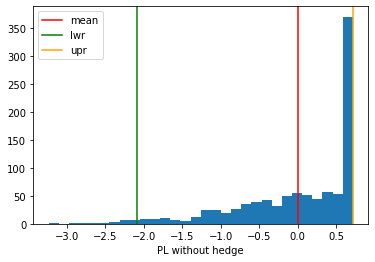

In [59]:
plt.hist(pl,bins=30)
plt.axvline(pl.mean(),color='red',label='mean') 
plt.axvline(np.quantile(pl,0.025),color='green',label='lwr')
plt.axvline(np.quantile(pl,0.975),color='orange',label='upr')
plt.xlabel('PL without hedge')
plt.legend()
plt.show()

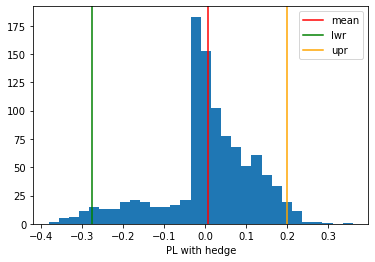

In [61]:
plh=port_val[:,-1]-np.maximum(s[:,-1]-K,0)  # profit/loss with hedging
plt.hist(plh,bins=30)
plt.axvline(plh.mean(),color='red',label='mean')
plt.axvline(np.quantile(plh,0.025),color='green',label='lwr')
plt.axvline(np.quantile(plh,0.975),color='orange',label='upr')
plt.xlabel('PL with hedge')
plt.legend()
plt.show()

**We see that with and without hedging the mean PL is $\sim 0$. But the range the distribution of PL is much more centered around $0$ in the hedged case than in the non-hedged case.**